Making classification data and getting it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

n_samples=1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

len(X), len(y)

(1000, 1000)

In [2]:
print(f"first 5 samples of X :\n{X[:5]}")
print(f"first 5 samples of y :\n{y[:5]}")

first 5 samples of X :
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y :
[1 1 1 1 0]


In [3]:
#making dataframe of circle data
import pandas as pd
circles=pd.DataFrame({"X1" : X[:,0],
                      "X2" : X[:,1],
                      "label" : y}
                    )
circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


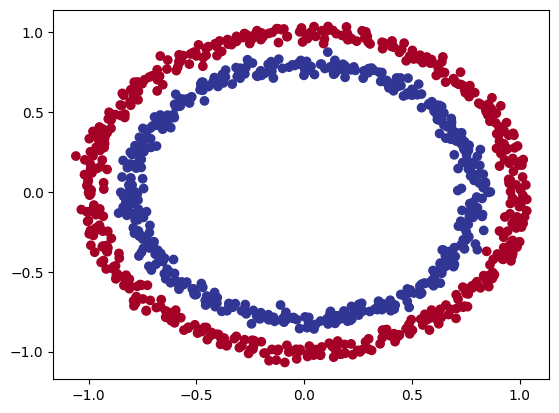

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [5]:
#checking input and output shape
X.shape,y.shape

((1000, 2), (1000,))

In [6]:
X_sample=X[0]
y_sample=y[0]
print(f"Value of one sample of X = {X_sample} and the same for y = {y_sample}")
print(f"Shape of one sample of X = {X_sample.shape} and the same for y = {y_sample.shape}")

Value of one sample of X = [0.75424625 0.23148074] and the same for y = 1
Shape of one sample of X = (2,) and the same for y = ()


#### converting data in tensors and creating train and test splits

In [7]:
#turning to tensors
import torch
X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [8]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
#spliting data into train and test sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               random_state=42
                                            )

len(X_train),len(y_train),len(X_test),len(y_test)

(800, 800, 200, 200)

#### Building a model


In [10]:
from torch import nn
#deice agnostics code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [11]:
# 1.creating a model that Subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear() layer that are capable of handling the shape of our data
        self.layer_1=nn.Linear(in_features=2,out_features=5)
        self.layer_2=nn.Linear(in_features=5,out_features=1)

    # 3.Defines a forward method() that outlines the forward pass of the model
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # x-> layer_1-> layer_2 ->output


model_0=CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# We can replicate the above model using nn.Sequential()
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.3645,  0.2757],
                      [ 0.3699, -0.7065],
                      [-0.0812, -0.5592],
                      [ 0.6019, -0.5471],
                      [-0.2699, -0.4729]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.4640, -0.2647, -0.5076, -0.0956, -0.5144], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1687,  0.0540, -0.2262, -0.0275, -0.4419]], device='cuda:0')),
             ('1.bias', tensor([0.0972], device='cuda:0'))])

In [14]:
#making predictions
with torch.inference_mode():
    untrained_preds= model_0(X_test.to(device))
print(f"Lenght of predictions : {len(untrained_preds)} , Shape: {untrained_preds.shape}")
print(f"Lenght of test sample : {len(X_test)} , Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Lenght of predictions : 200 , Shape: torch.Size([200, 1])
Lenght of test sample : 200 , Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[0.6749],
        [0.8536],
        [0.2506],
        [0.7950],
        [0.3205],
        [0.4290],
        [0.8767],
        [0.7774],
        [0.2483],
        [0.8663]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [15]:
# setting up loss function
loss_fn= nn.BCEWithLogitsLoss() #BCEWithLogitsLossk has a built-in sigmoid activation function

optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

In [16]:
# calculating the accuracy
# Acuracy is what percentage our model get right
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc= (correct/len(y_pred))*100
    return acc

Training a model

In [17]:
# viewing logits
model_0.eval()
with torch.inference_mode():
    y_logits= model_0(X_test.to(device))[:5]
y_logits

tensor([[0.6749],
        [0.8536],
        [0.2506],
        [0.7950],
        [0.3205]], device='cuda:0')

In [18]:
#using sigmoid activation function on our model logits

y_preds_probs=torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.6626],
        [0.7013],
        [0.5623],
        [0.6889],
        [0.5794]], device='cuda:0')

In [19]:
torch.round(y_preds_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [20]:
#finding the prediction labels
y_preds= torch.round(y_preds_probs)

# In full (logits -> preds probs -> pred labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

#check for equality
print(torch.eq(y_preds.squeeze() , y_preds_labels.squeeze()))

#get rid of extra dimension
y_preds.squeeze()



tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [21]:
torch.manual_seed(42)

#set the number of epochs

epochs=100
# putting data to target device if gpu is available



""" little jingle to learn steps for training loop
    for epoch in range
    do model.train
    do the forwrd pass
    calculate the loss
    optimizer zero grad
    loss backwards
    optimise the step
"""
for epoch in range(epochs):
    # train
    model_0.train()

    # forward pass
    y_logits = model_0(X_train.to(device)).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # calculate the loss
    loss = loss_fn(y_logits.to(device),
                   y_train.to(device))

    acc=accuracy_fn(y_true=y_train.to(device), #nn.BCEWithLogitsLoss expect raw logits as input
                    y_pred=y_preds.to(device))

    # optimizes the zero grad
    optimizer.zero_grad()
    # loss backwards
    loss.backward()
    # optimize the step
    optimizer.step()



    # testing
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits=model_0(X_test.to(device)).squeeze()
        test_pred= torch.round(torch.sigmoid(test_logits))
        # 2. calculate the loss
        test_loss= loss_fn(test_logits.to(device),
                        y_test.to(device))

        test_acc= accuracy_fn(y_true=y_test.to(device),
                            y_pred=test_pred)

        # print ehats happening
        if epoch % 10 == 0:
            print(f"Epoch : {epoch} | Loss : {loss:.5f} | Acc : {acc:.2f}% | Test Loss :{test_loss:.5f} | Test acc : {test_acc:.2f}%")

Epoch : 0 | Loss : 0.72964 | Acc : 50.00% | Test Loss :0.74156 | Test acc : 50.00%
Epoch : 10 | Loss : 0.70611 | Acc : 54.37% | Test Loss :0.71507 | Test acc : 54.00%
Epoch : 20 | Loss : 0.69812 | Acc : 55.62% | Test Loss :0.70513 | Test acc : 51.50%
Epoch : 30 | Loss : 0.69528 | Acc : 53.87% | Test Loss :0.70105 | Test acc : 47.50%
Epoch : 40 | Loss : 0.69421 | Acc : 52.12% | Test Loss :0.69921 | Test acc : 47.50%
Epoch : 50 | Loss : 0.69378 | Acc : 51.50% | Test Loss :0.69829 | Test acc : 47.00%
Epoch : 60 | Loss : 0.69359 | Acc : 50.75% | Test Loss :0.69777 | Test acc : 46.50%
Epoch : 70 | Loss : 0.69348 | Acc : 50.62% | Test Loss :0.69744 | Test acc : 47.50%
Epoch : 80 | Loss : 0.69342 | Acc : 50.38% | Test Loss :0.69721 | Test acc : 48.00%
Epoch : 90 | Loss : 0.69337 | Acc : 50.62% | Test Loss :0.69704 | Test acc : 47.00%


In [22]:
import requests
from pathlib import Path

#download helper function from Learn PyTorch repo(if it's not downloaded)
if Path("helper_functions.py").is_file():
    print("Helper function already exists skipping download")

else:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

    from helper_functions import plot_predictions, plot_decision_boundary

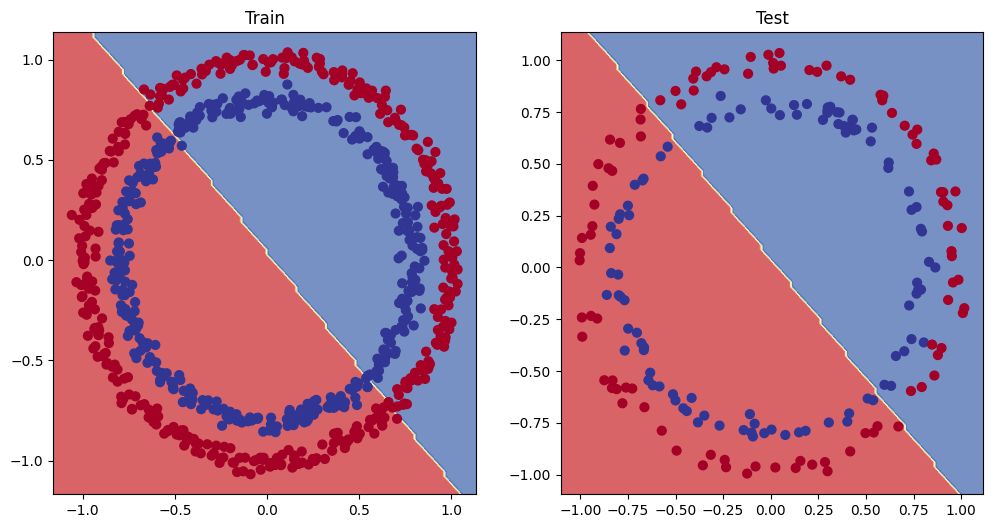

In [23]:
# plot prediction boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test, y_test)


### Imporving our model
- Adding more layers
- Add more hidden layers
- Fit for longer
- changing the learning rate
- change the loss function

These options are all from the model's perspective beacuse they deal directly with the model rather than data

We can change the **hyperparamteres**

In [24]:

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1= nn.Linear(in_features=2,out_features=10)
        self.layer_2=nn.Linear(in_features=10,out_features=10)
        self.layer_3=nn.Linear(in_features=10,out_features=1)

    def forward(self,x):
        # z=self.layer_1(x)
        # z=self.layer_2(z)
        # z=self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1=CircleModelV1()

Adding loss function and optimizer

In [25]:
import torch
# creating a loss function
loss_fn=nn.BCEWithLogitsLoss()

# Creating an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [26]:
# writing training and testing loop
torch.manual_seed(42)

epochs =1000

# put data in target device
"""pytorch song
for epoch in range
do the forward pass
calculate the lossl
optimize the zero grad
loss backward
optimizer step"""
for epoch in range(epochs):
    #training
    model_1.train()

    # 1. forward passs
    y_logits= model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_preds))

    # 2. calculate the loss

    loss=loss_fn(y_logits,y_train)
    acc= accuracy_fn(y_true=y_train.to(device),
                     y_pred=y_pred.to(device))

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # optimizer step
    optimizer.step()

    #testing

    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits =model_1(X_test).squeeze()
        tese_preds=torch.round(torch.sigmoid(test_logits))
        # 2. calculate the loss
        test_loss=loss_fn(test_logits,
                          y_test)
        test_acc = accuracy_fn(y_true=y_test.to(device),
                               y_pred=test_pred.to(device))

    # Print what's happenin'
    if epoch %100 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.5f} | Acc : {acc:.2f}% | Test Loss :{test_loss:.5f} | Test acc : {test_acc:.2f}%")

Epoch : 0 | Loss : 0.69396 | Acc : 50.50% | Test Loss :0.69261 | Test acc : 47.50%
Epoch : 100 | Loss : 0.69305 | Acc : 50.50% | Test Loss :0.69379 | Test acc : 47.50%
Epoch : 200 | Loss : 0.69299 | Acc : 50.50% | Test Loss :0.69437 | Test acc : 47.50%
Epoch : 300 | Loss : 0.69298 | Acc : 50.50% | Test Loss :0.69458 | Test acc : 47.50%
Epoch : 400 | Loss : 0.69298 | Acc : 50.50% | Test Loss :0.69465 | Test acc : 47.50%
Epoch : 500 | Loss : 0.69298 | Acc : 50.50% | Test Loss :0.69467 | Test acc : 47.50%
Epoch : 600 | Loss : 0.69298 | Acc : 50.50% | Test Loss :0.69468 | Test acc : 47.50%
Epoch : 700 | Loss : 0.69298 | Acc : 50.50% | Test Loss :0.69468 | Test acc : 47.50%
Epoch : 800 | Loss : 0.69298 | Acc : 50.50% | Test Loss :0.69468 | Test acc : 47.50%
Epoch : 900 | Loss : 0.69298 | Acc : 50.50% | Test Loss :0.69468 | Test acc : 47.50%


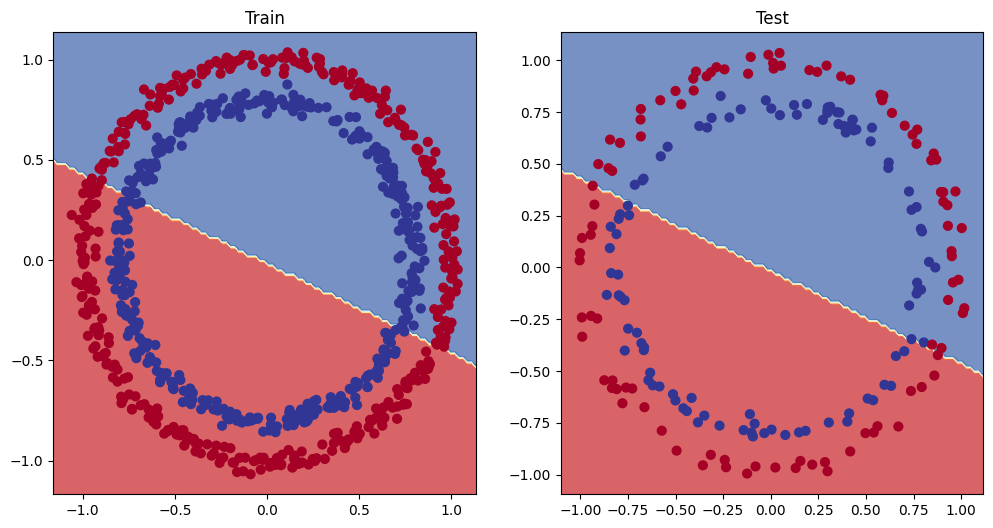

In [27]:
# plot prediction boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test, y_test)


In [28]:
# create some data (as in notebook 01)

weight =0.7
bias=0.3

start =0
end=1
step=0.01


#Create datal
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight* X_regression # Linear regression formula

# check the data
print(len(X_regression))
X_regression[:5] ,y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.0000],
         [0.0070],
         [0.0140],
         [0.0210],
         [0.0280]]))

In [29]:
#creating training and testing splits
train_split=int(0.8*len(X_regression))
X_train_regression ,y_train_regression=X_regression[:train_split],y_regression[:train_split]
X_test_regression,y_test_regression=X_regression[train_split:],y_regression[train_split:]


#checking len of each

len(X_train_regression),len(X_test_regression),len(y_train_regression),len(y_test_regression)


(80, 20, 80, 20)

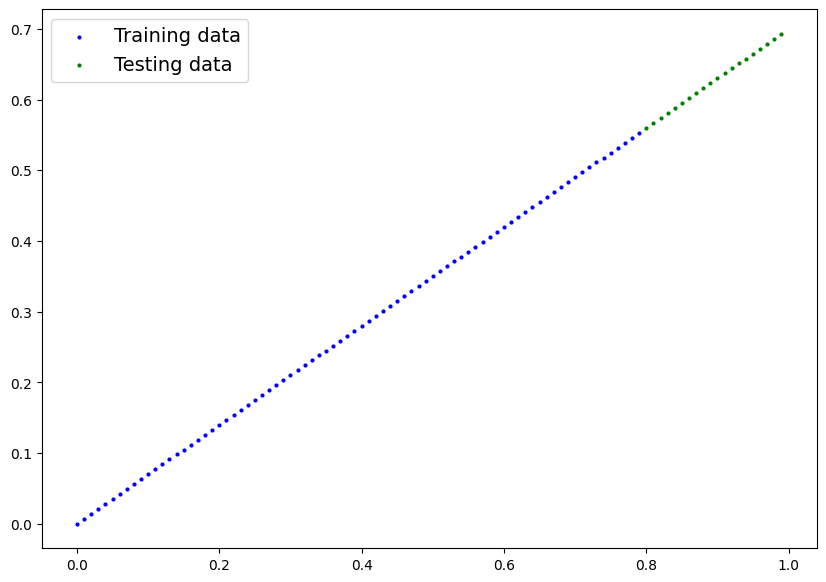

In [30]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

Adjusting model_1 to fit a straight line

In [31]:
# Same architecture as model_1 (but using nn.sequential())
model_2=nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1),
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Loss and optimizer
loss_fn= nn.L1Loss()
optimizer=torch.optim.SGD(params=model_2.parameters(),
                          lr=0.01)

In [33]:
# training and testing
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# setting epochs
epochs=1000

# putting data on target device
X_train_regression,y_train_regression=X_train_regression.to(device),y_train_regression.to(device)
X_test_regression,y_test_regression=X_test_regression.to(device),y_test_regression.to(device)

#training

for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)
  loss=loss_fn(y_pred,y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  # testing
  model_2.eval()
  with torch.inference_mode():
    test_pred= model_2(X_test_regression)
    test_loss=loss_fn(test_pred,y_test_regression)


  # printing what's happening
  if epoch %100 == 0:
    print(f"Epoch : {epoch} | Loss : {loss:.5f} | Test Loss :{test_loss:.5f} ")

Epoch : 0 | Loss : 0.45986 | Test Loss :0.61103 
Epoch : 100 | Loss : 0.02706 | Test Loss :0.02242 
Epoch : 200 | Loss : 0.01908 | Test Loss :0.03738 
Epoch : 300 | Loss : 0.01446 | Test Loss :0.04252 
Epoch : 400 | Loss : 0.01444 | Test Loss :0.04328 
Epoch : 500 | Loss : 0.01407 | Test Loss :0.04223 
Epoch : 600 | Loss : 0.01429 | Test Loss :0.04070 
Epoch : 700 | Loss : 0.01347 | Test Loss :0.03941 
Epoch : 800 | Loss : 0.01365 | Test Loss :0.03892 
Epoch : 900 | Loss : 0.01264 | Test Loss :0.03686 


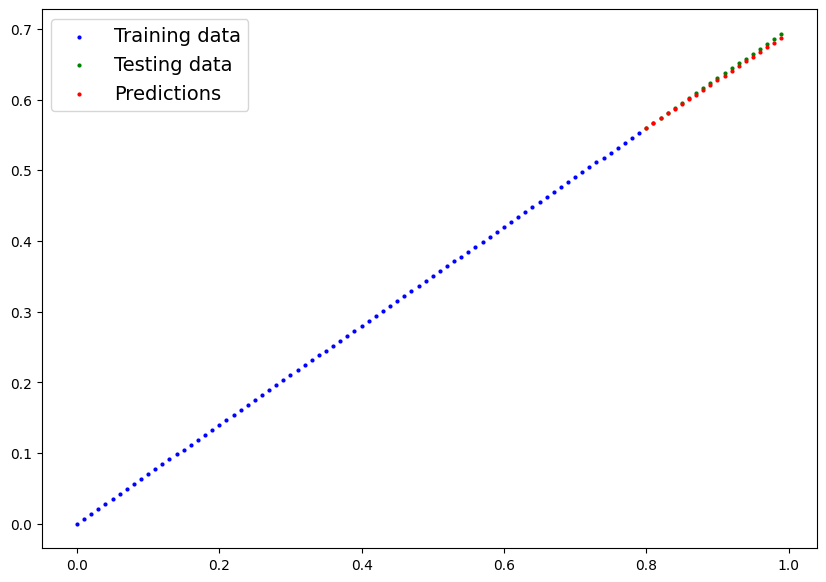

In [34]:
# turn on eval mode
model_2.eval()
with torch.inference_mode():
  y_preds=model_2(X_test_regression)

#plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

### Done with 11:51:26

### Introduction to non linearity
timestamp: 11:51:26 - 12:01:26


#### The missing piece :: introduction to Non-Linear Functons of pytorch

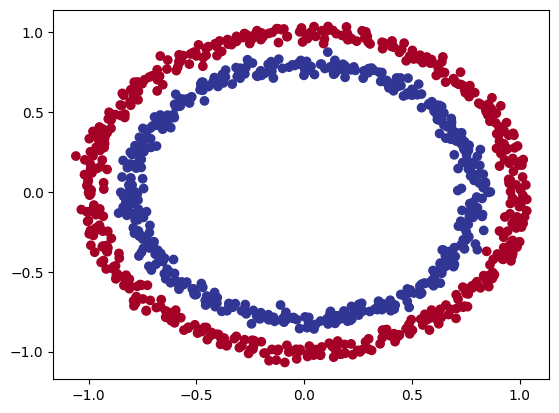

In [35]:
# recreating non linear data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples= 1000

X,y= make_circles(n_samples,
                  noise=0.03,
                  random_state=42)

plt.scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.RdYlBu)

In [36]:
#converting to tensor and making traing and testing splits
import torch
from sklearn.model_selection import train_test_split

# Converting to tensors
# X=torch.from_numpy(X).type(torch.float)
# y=torch.from_numpy(y).type(torch.float)

# splits into  train and test splits
X_train ,X_test ,y_train,y_test=train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

X_train[:5],y_train[:5]

(array([[ 0.65794626, -0.46508097],
        [ 0.63194897, -0.7346633 ],
        [-1.00861631, -0.12403051],
        [-0.96657519, -0.22562157],
        [-0.16659009,  0.79944645]]),
 array([1, 0, 0, 0, 1]))

## Building first model of non linearity
Date: 28 june 2025
timestamp: 12:01:27 - 12:11:54

In [37]:
# building a model with non linear function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
      super().__init__()
      self.layer_1=nn.Linear(in_features=2,out_features=10)
      self.layer_2=nn.Linear(in_features=10,out_features=10)
      self.layer_3=nn.Linear(in_features=10,out_features=1)
      self.relu=nn.ReLU()# relu is a non linear activation function

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3=CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## Building first model of non linearity
# Date: 28 june 2025
timestamp: 12:11:54 -12:27:06

Artificial neural networks are a large combination Linear and Non-Linear which are potentially able to find patterns in data.

In [38]:
# setting up optimizer an d loss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)


Training and testing loop with non linearity

In [39]:
# Random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#putting tensors to device
X_train,y_train =(torch.from_numpy(X_train)).to(device),(torch.from_numpy(y_train)).to(device)
X_test,y_test =(torch.from_numpy(X_test)).to(device),(torch.from_numpy(y_test)).to(device)

# loop through data
epochs= 1000

# training loop
for epoch in range(epochs):
  model_3.train()

  # forward pass
  y_logits=model_3(X_train.float()).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # calculate the loss
  loss= loss_fn(y_logits.float(),y_train.float())
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #optimizer the zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  # optimizer step
  optimizer.step()

  #testing
  model_3.eval()
  with torch.inference_mode():
    test_logits= model_3(X_test.float()).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits.float(),y_test.float())
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)

    # print out what's happening
    if epoch %100 ==0 or epoch ==999 :
      print(f"Epoch : {epoch} |Loss : {loss : .4f}| Accuracy :{acc:.2f}%| test Loss : {test_loss:.4f}| Test Acc :{ test_acc: .2f}%")

Epoch : 0 |Loss :  0.6929| Accuracy :50.00%| test Loss : 0.6932| Test Acc : 50.00%
Epoch : 100 |Loss :  0.6912| Accuracy :52.88%| test Loss : 0.6910| Test Acc : 52.50%
Epoch : 200 |Loss :  0.6898| Accuracy :53.37%| test Loss : 0.6894| Test Acc : 55.00%
Epoch : 300 |Loss :  0.6879| Accuracy :53.00%| test Loss : 0.6872| Test Acc : 56.00%
Epoch : 400 |Loss :  0.6852| Accuracy :52.75%| test Loss : 0.6841| Test Acc : 56.50%
Epoch : 500 |Loss :  0.6810| Accuracy :52.75%| test Loss : 0.6794| Test Acc : 56.50%
Epoch : 600 |Loss :  0.6751| Accuracy :54.50%| test Loss : 0.6729| Test Acc : 56.00%
Epoch : 700 |Loss :  0.6666| Accuracy :58.38%| test Loss : 0.6632| Test Acc : 59.00%
Epoch : 800 |Loss :  0.6516| Accuracy :64.00%| test Loss : 0.6476| Test Acc : 67.50%
Epoch : 900 |Loss :  0.6236| Accuracy :74.00%| test Loss : 0.6215| Test Acc : 79.00%
Epoch : 999 |Loss :  0.5689| Accuracy :87.62%| test Loss : 0.5744| Test Acc : 86.50%


timestamp: 12:27:06 - 12:32:55
### Making predictions form our trained model

In [40]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_3(X_test.float()))).squeeze()
y_preds[:10],y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0], device='cuda:0'))

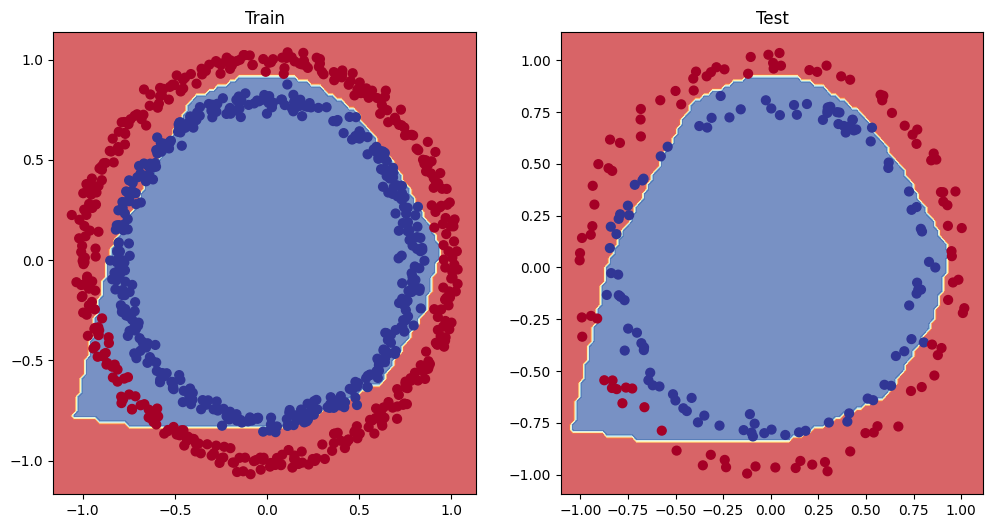

In [41]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,y_test)

timestamp: 12:32:56 - 12:42:32
### Replicating non-linear activation function with pure pytorch


- *Neural networks themselves learns patterns in data from the tools we provide them, these tools are linear and non-linear activation functions.*

In [42]:
# creating a tensor
A= torch.arange(-10,10,1,dtype=torch.float32)
A.dtype

torch.float32

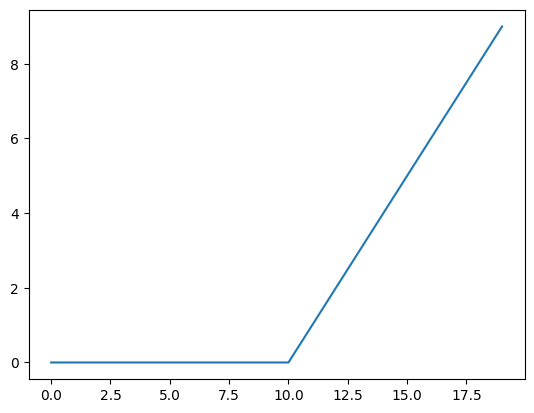

In [43]:
plt.plot(torch.relu(A))

In [44]:
def relu(x:torch.Tensor)->torch.Tensor:
  return torch.maximum(torch.tensor(0),x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

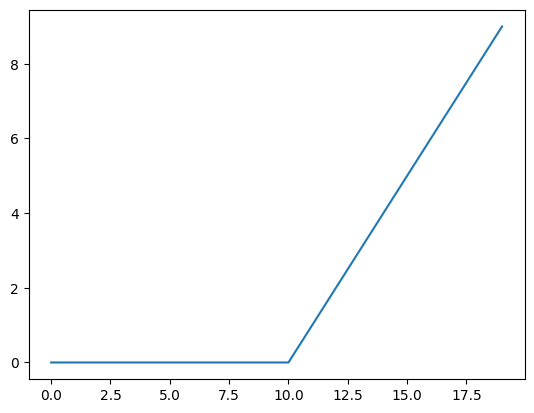

In [45]:
#ploting custom relu activation function
plt.plot(relu(A))

In [46]:
# doing same for sigmoid function.
def sigmoid(x:torch.Tensor)->torch.Tensor:
  return 1/(1+torch.exp(-x))

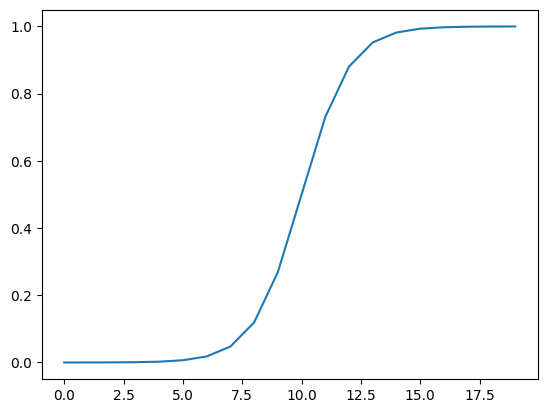

In [47]:
plt.plot(torch.sigmoid(A))

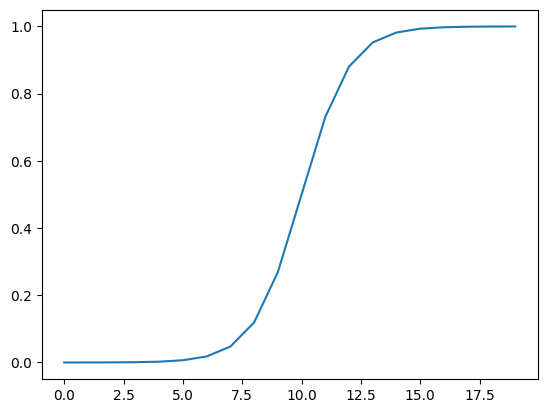

In [48]:
plt.plot(sigmoid(A))

timestamp: 12:42:32 - 12:53:55
### Putting it all together for classification Problem. Creating a multi class data-set
# *$Part-1$*

### Creating a toy multi-class dataset

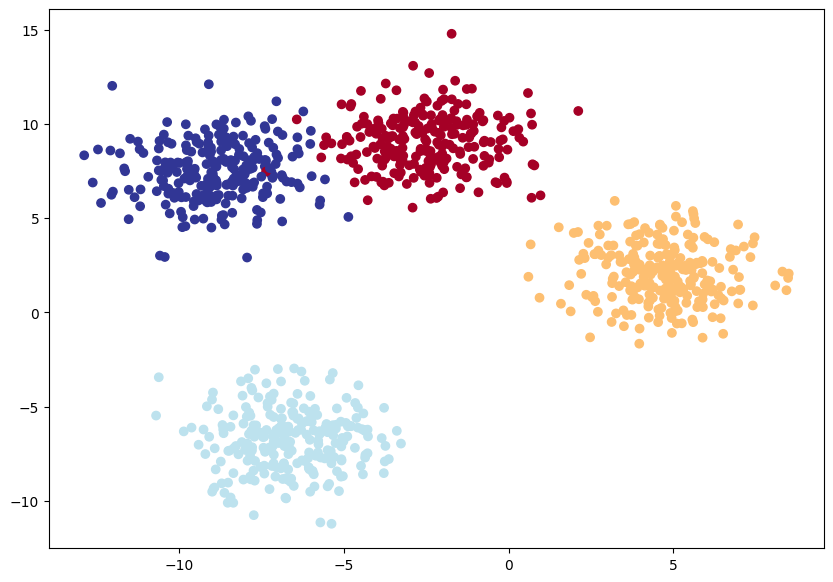

In [83]:
#import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Setting hyperparameters for data creation
NUM_CLASSES =4
NUM_FEATURES =2
RANDOM_SEED=42

# 1. CREATING MULTI CLASS DATA
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)

# 2. turn data into tensor
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Splits into train and test
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,
                                                                   y_blob,
                                                                   test_size=0.2,
                                                                   random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

timestamp:  12:53:56 - 13:06:25
### putting it all together Creating a multi class classification model

# *$Part- 2 (As Per The Video)$*

In [85]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [86]:
# building a multi-class classificaion model in PyTorch

class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units):
    super().__init__()
    self.linear_layer_stack= nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
     return self.linear_layer_stack(x)

# creating an instance of BlobModel
model_4=BlobModel(input_features=2,
                  output_features=4,
                  hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

timestamp: 13:06:25 - 13:13:05
### putting it all together Setting up loss function and optimizer for multi class classification model

# *$Part- 3(As Per The Video)$*

In [87]:
# Creating a loss function and optimizer
loss_fn= nn.CrossEntropyLoss()

# Creating an optimizer for multi-class classification
optimizer= torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1)


timestamp: 13:13:05 - 13:24:09
### putting it all togetherGoing from logits -> prediction probabilities -> orediction labels with a multi-class model

# *$Part- 4(As Per The Video)$*

Getting prediction probablities for multi-class PyTorch Model

* *In order to to evualate test nd train our model we need to convert our model;s output(logits) to predict probablities and them to prediction labels*

**$$logits -> preds probablities -> preds labels$$**

In [88]:
# getting raw from model logits
model_4.eval()
with torch.inference_mode():
  y_logits=model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.1107, -0.3894, -0.2437, -0.1255],
        [-1.4268,  1.5669,  0.7640,  0.0971],
        [-0.5373,  0.6497,  0.7963, -1.3189],
        [-0.0944, -0.1988, -0.0890, -0.2506],
        [-0.8032,  0.7063,  0.2875, -0.1650],
        [-1.6619,  1.8704,  0.9198,  0.1082],
        [-0.4085,  0.5976,  0.7641, -1.3293],
        [-1.0092,  1.0204,  0.4781,  0.0083],
        [-0.6115,  0.6955,  1.0079, -1.6790],
        [-0.9161,  0.8899,  0.3978, -0.0586]], device='cuda:0')

In [89]:
# converting model's logits to output prediction probablities
y_pred_probs = torch.softmax(y_logits,dim=1)
y_logits[:5],y_preds_probs[:5]


(tensor([[-0.1107, -0.3894, -0.2437, -0.1255],
         [-1.4268,  1.5669,  0.7640,  0.0971],
         [-0.5373,  0.6497,  0.7963, -1.3189],
         [-0.0944, -0.1988, -0.0890, -0.2506],
         [-0.8032,  0.7063,  0.2875, -0.1650]], device='cuda:0'),
 tensor([[0.6626],
         [0.7013],
         [0.5623],
         [0.6889],
         [0.5794]], device='cuda:0'))

In [90]:
torch.sum(y_pred_probs[0]),torch.max(y_pred_probs[0])

(tensor(1., device='cuda:0'), tensor(0.2764, device='cuda:0'))

In [91]:
# converting model's predictions probablities to prediction labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([0, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2,
        2, 2, 1, 1, 0, 1, 1, 0, 0, 1, 0, 2, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1,
        1, 1, 0, 1, 2, 2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 2, 1, 1, 1, 0, 2,
        2, 1, 1, 0, 2, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2,
        2, 2, 1, 1, 1, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 2, 1,
        2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 2, 2, 1, 0, 2, 2, 1, 1,
        0, 1, 2, 1, 1, 0, 2, 0], device='cuda:0')

timestamp:  13:24:09 - 13:40:26
### putting it all together training a multi class classification model

# *$Part- 5(As Per The Video)$*

Training and testing loop for model

In [92]:
#
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# setting epochs
epochs=100

#putting data to device

X_blob_train,y_blob_train=X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test=X_blob_test.to(device),y_blob_test.to(device)


for epoch in range(epochs):
  model_4.train()

  y_logits=model_4(X_blob_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)


  loss=loss_fn(y_logits,y_blob_train)
  acc= accuracy_fn(y_true=y_blob_train,
                   y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()



  ## testing

  model_4.eval()
  with torch.inference_mode():
    test_logits= model_4(X_blob_test)
    test_preds= torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss=loss_fn(test_logits,y_blob_test)
    test_acc=accuracy_fn(y_true=y_blob_test,
                         y_pred=test_preds)

    ## print out whats happening
    if epoch% 10 ==0 or epoch ==99:
      print(f"epoch : {epoch} |Loss :{loss:.4f} | Acc: {acc :.2f}% | Test loss : {test_loss: .4f} test acc :{test_acc :.2f}%")


epoch : 0 |Loss :1.8103 | Acc: 25.00% | Test loss :  1.2605 test acc :55.00%
epoch : 10 |Loss :0.7781 | Acc: 58.13% | Test loss :  0.6782 test acc :67.50%
epoch : 20 |Loss :0.4693 | Acc: 97.75% | Test loss :  0.3908 test acc :99.00%
epoch : 30 |Loss :0.2387 | Acc: 99.25% | Test loss :  0.1927 test acc :99.50%
epoch : 40 |Loss :0.1241 | Acc: 99.00% | Test loss :  0.1000 test acc :99.50%
epoch : 50 |Loss :0.0808 | Acc: 99.12% | Test loss :  0.0647 test acc :99.50%
epoch : 60 |Loss :0.0619 | Acc: 99.12% | Test loss :  0.0487 test acc :99.50%
epoch : 70 |Loss :0.0517 | Acc: 99.25% | Test loss :  0.0398 test acc :99.50%
epoch : 80 |Loss :0.0454 | Acc: 99.12% | Test loss :  0.0343 test acc :99.50%
epoch : 90 |Loss :0.0412 | Acc: 99.12% | Test loss :  0.0305 test acc :99.50%
epoch : 99 |Loss :0.0385 | Acc: 99.12% | Test loss :  0.0280 test acc :99.50%


timestamp: 13:40:27 - 13:48:27
### putting it all together making prediction with multi class classification model

# *$Part- 6(As Per The Video)$*

In [93]:
# Making and evualating plot_predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# view the first predictions
y_logits[:10]

tensor([[  1.8010,   6.9753,  -1.9064,  -8.5833],
        [  6.0640,  -8.7035,  -0.8341,  10.3069],
        [ -3.2202,  -0.2630,   6.7043,  -3.8144],
        [  0.6194,   4.2588,  -1.1308,  -5.1340],
        [  6.3317,   2.0018,  -2.2996,  -4.1920],
        [  7.0670, -10.4601,  -0.8710,  12.3922],
        [ -2.8993,   0.6844,   5.9494,  -4.3021],
        [  6.2920,  -1.0214,  -2.0970,  -0.2608],
        [ -3.3557,  -1.9987,   8.1507,  -2.8825],
        [  6.2346,   0.1181,  -2.0814,  -1.7961]], device='cuda:0')

In [94]:
# go from logits to predictions probablities
y_pred_probs= torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[5.6279e-03, 9.9423e-01, 1.3811e-04, 1.7397e-07],
        [1.4162e-02, 5.4659e-09, 1.4300e-05, 9.8582e-01],
        [4.8911e-05, 9.4123e-04, 9.9898e-01, 2.7001e-05],
        [2.5479e-02, 9.7001e-01, 4.4269e-03, 8.0820e-05],
        [9.8680e-01, 1.2995e-02, 1.7607e-04, 2.6536e-05],
        [4.8437e-03, 1.1837e-10, 1.7287e-06, 9.9515e-01],
        [1.4281e-04, 5.1419e-03, 9.9468e-01, 3.5116e-05],
        [9.9769e-01, 6.6505e-04, 2.2683e-04, 1.4229e-03],
        [1.0065e-05, 3.9099e-05, 9.9993e-01, 1.6156e-05],
        [9.9723e-01, 2.2000e-03, 2.4389e-04, 3.2441e-04]], device='cuda:0')

In [95]:
y_preds=torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

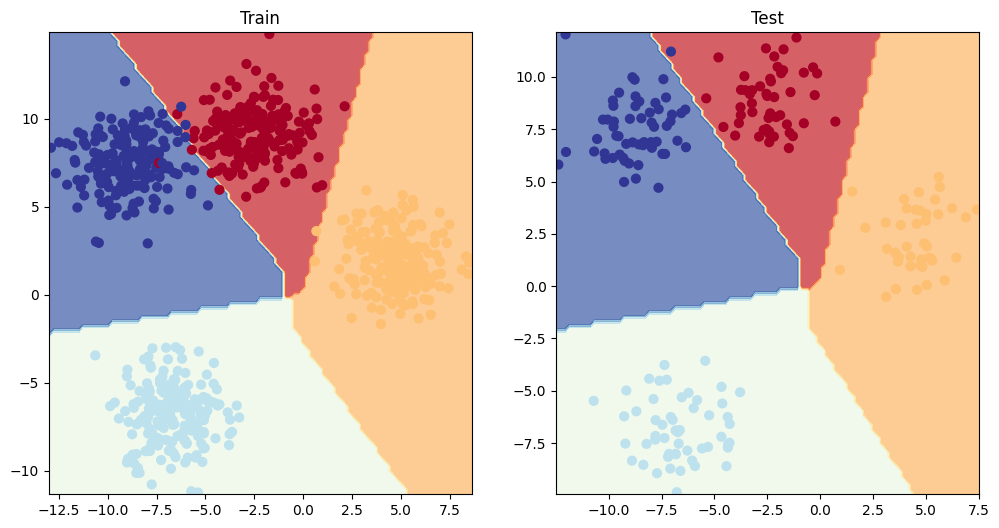

In [96]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)